# Sensor shape optimization workflow

In this example we will show how to use MaMMoS for shape optimization of a magnetic sensor element. To show the versatility of the mammos software we will perform the micromagnetic simulations with the `ubermag` micromagnetic package.

In this workflow we optimize the region of the hysteresis loop over which M vs H has a linear reponse. In order to do this we will first obtain micromagnetic parameters, perform micromagnetic simulations, and then analyze the hysteresis loop.

This is followed by Baysian optimization to maximize the linear region.

Requirements:
- Software: `mammos`, `ubermag` with OOMMF, `bayesian-optimization`
- Basic understanding of [mammos-units](https://mammos-project.github.io/mammos/examples/mammos-units/quickstart.html) and [mammos-entity](https://mammos-project.github.io/mammos/examples/mammos-entity/quickstart.html)

In [1]:
%config InlineBackend.figure_format = "retina"

import numpy as np

# Ubermag imports
import micromagneticdata as md
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as mc

# MaMMoS imports
import mammos_analysis
import mammos_spindynamics
import mammos_entity as me
import mammos_units as u

In [2]:
%config InlineBackend.figure_format = "retina"


# MaMMoS imports

In [3]:
# Allow convenient conversions between A/m and T
u.set_enabled_equivalencies(u.magnetic_flux_field());

## Temperature-dependent magnetization data from spindynamics database lookup

In order to get micromagnetic parameters we use pre-computed data from `mammos_spindynamics.db` for the temperature-dependent magnetization.

In [4]:
results_spindynamics = mammos_spindynamics.db.get_spontaneous_magnetization("Nd2Fe14B")  # TODO: change material

We can visualize the pre-computed data using `.plot`.

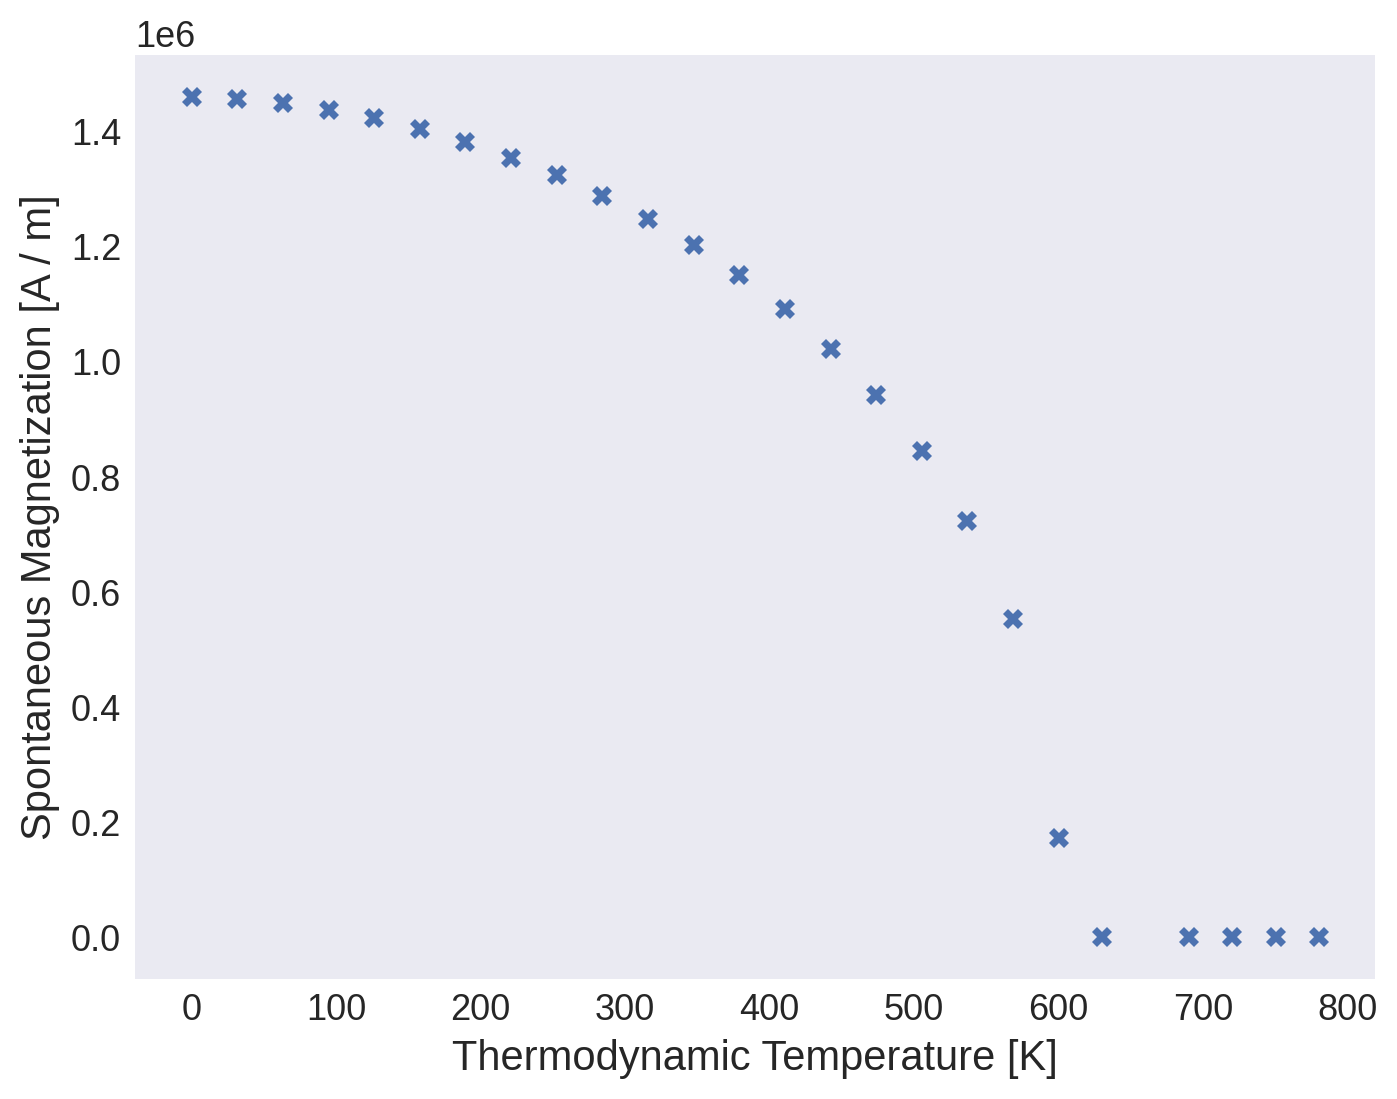

In [5]:
results_spindynamics.plot(marker="X");

We can access `T` and `Ms` and get `mammos_entity.Entity` objects:

In [6]:
results_spindynamics.T

ThermodynamicTemperature(value=
[  0.          31.57894737  63.15789474  94.73684211 126.31578947
 157.89473684 189.47368421 221.05263158 252.63157895 284.21052632
 315.78947368 347.36842105 378.94736842 410.52631579 442.10526316
 473.68421053 505.26315789 536.84210526 568.42105263 600.
 630.         690.         720.         750.         780.        ],
 unit=K)

In [7]:
results_spindynamics.Ms

SpontaneousMagnetization(value=
[1460000.         1456985.36046193 1449449.93657199 1437972.77253639
 1422736.58364638 1403779.39648225 1381044.11152378 1354391.97626968
 1323600.99407897 1288353.67899904 1248213.31769096 1202584.11677895
 1150645.20320241 1091237.80552561 1022660.54963577  942263.95974459
  845538.33920183  723617.755767    553555.21471405  171781.14820705
       0.               0.               0.               0.
       0.        ],
 unit=A / m)

## Calculate micromagnetic intrinsic properties using Kuz’min formula

We use Kuz’min equations to compute Ms(T) and A(T).

In [8]:
kuzmin_result = mammos_analysis.kuzmin_properties(
    T=results_spindynamics.T,
    Ms=results_spindynamics.Ms,
)

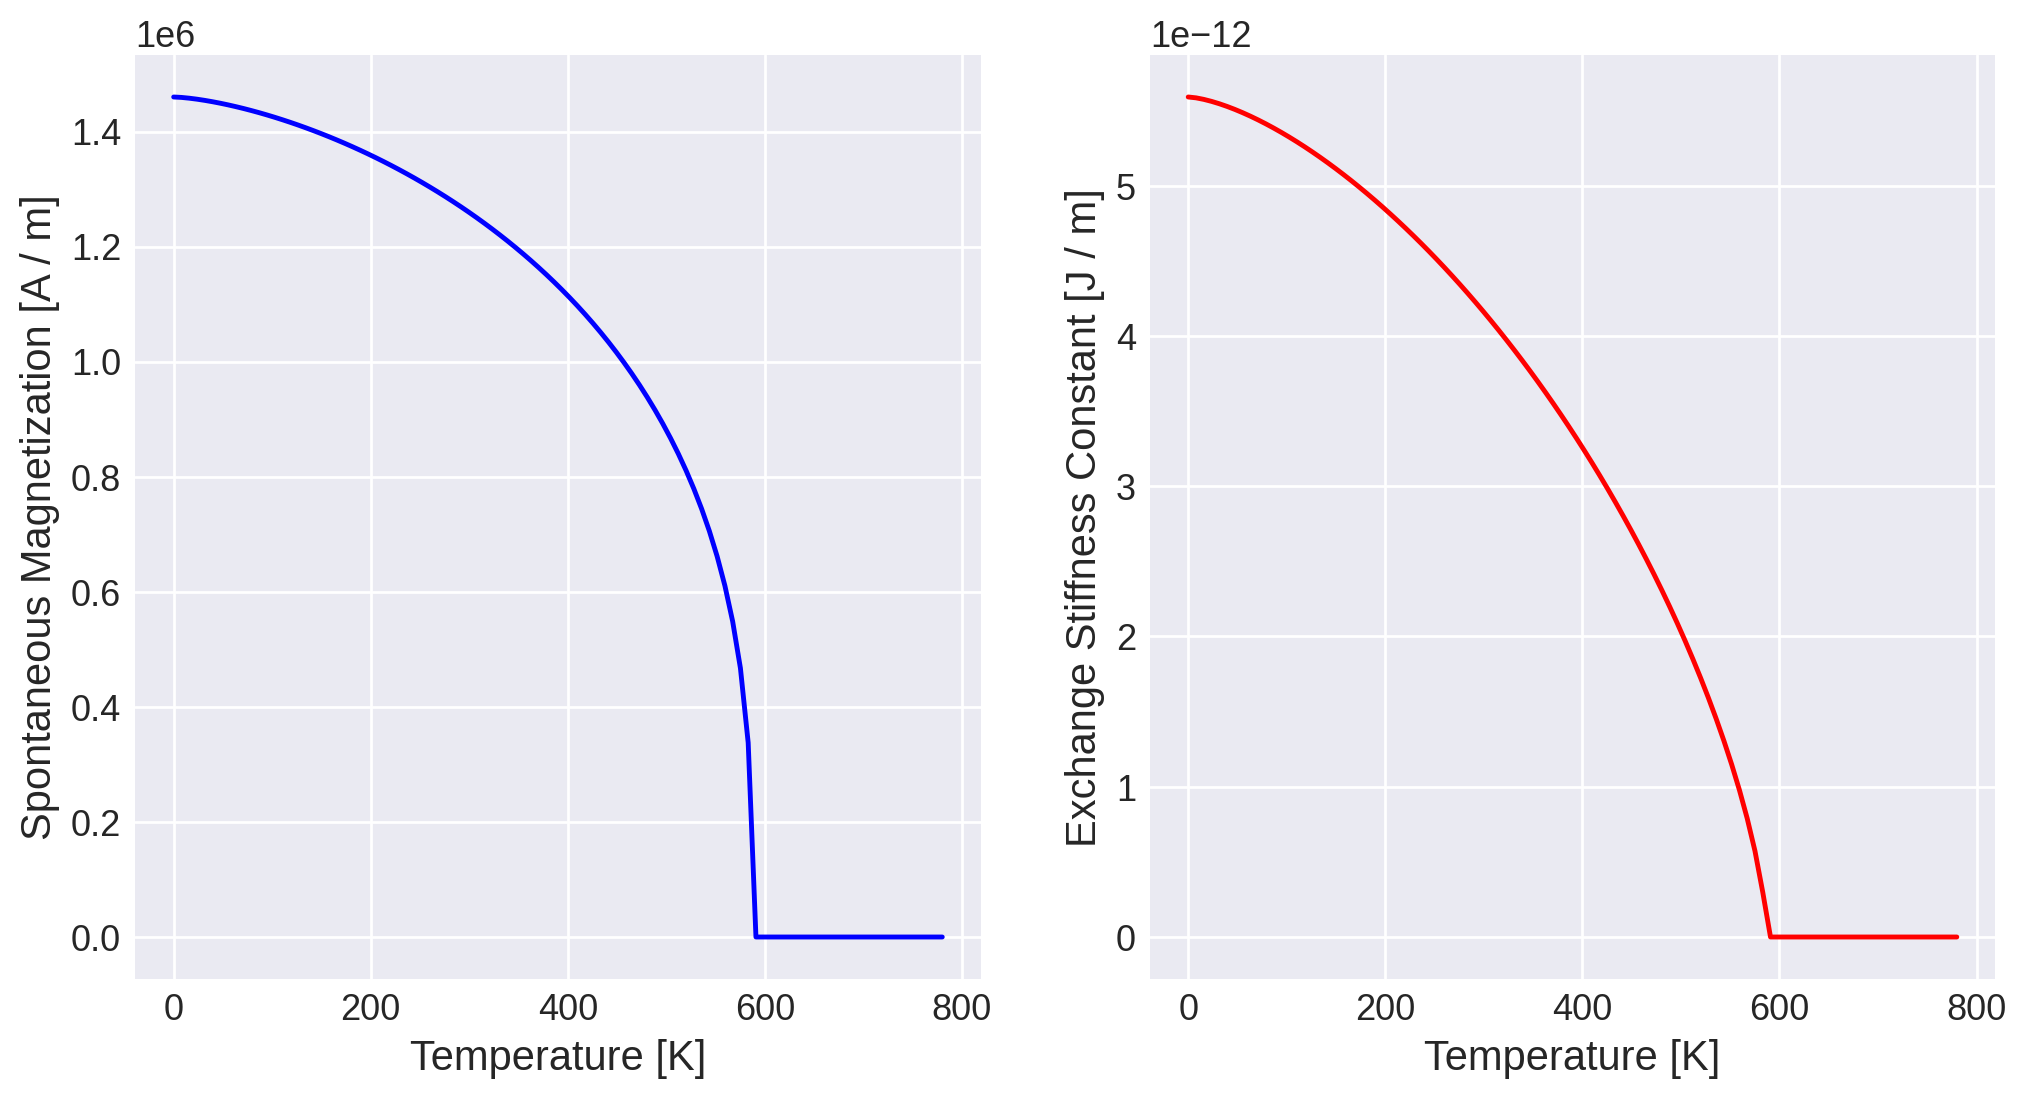

In [9]:
kuzmin_result.plot();

# Setting up the micromagnetic simulation
Run the micromagnetic simulation with parameters at 300 K using [ubermag](https://ubermag.github.io) with OOMMF as calculator.

In [10]:
T = me.T(300, unit="K")

Define the energy equation of the system.

In [11]:
system = mm.System(name="sensor")
A = me.A(11e-12)  # kuzmin_result.A(T) TODO: change when material is updated
Ms = me.Ms(0.84e6)  # kuzmin_result.Ms(T) TODO: change when material is updated
system.energy = mm.Exchange(A=A.value) + mm.Demag() + mm.Zeeman(H=(0, 0, 0))

Initialize the magnetization: we constrain the shape of our sensor to be a diamond (rhombus) with the distance $s_x$ and $s_y$  from origin to corners along the $x$ and $y$ directions, respectively, and with thickness $t$. We create a $100\times 100\times 5$ nm region in which we create the diamond shape of magnetic material.

In [12]:
L = 100e-9  # nm
t = 5e-9  # nm
region = df.Region(p1=(-L / 2, -L / 2, -t / 2), p2=(L / 2, L / 2, t / 2))
mesh = df.Mesh(region=region, n=(40, 40, 1))


def in_diamond(position, sx, sy):
    x, y, _ = position
    if abs(x) / sx + abs(y) / sy <= 1:
        return Ms.value
    else:
        return 0


system.m = df.Field(mesh, nvdim=3, value=(1, 0, 0), norm=lambda p: in_diamond(p, 40e-9, 30e-9), valid="norm")

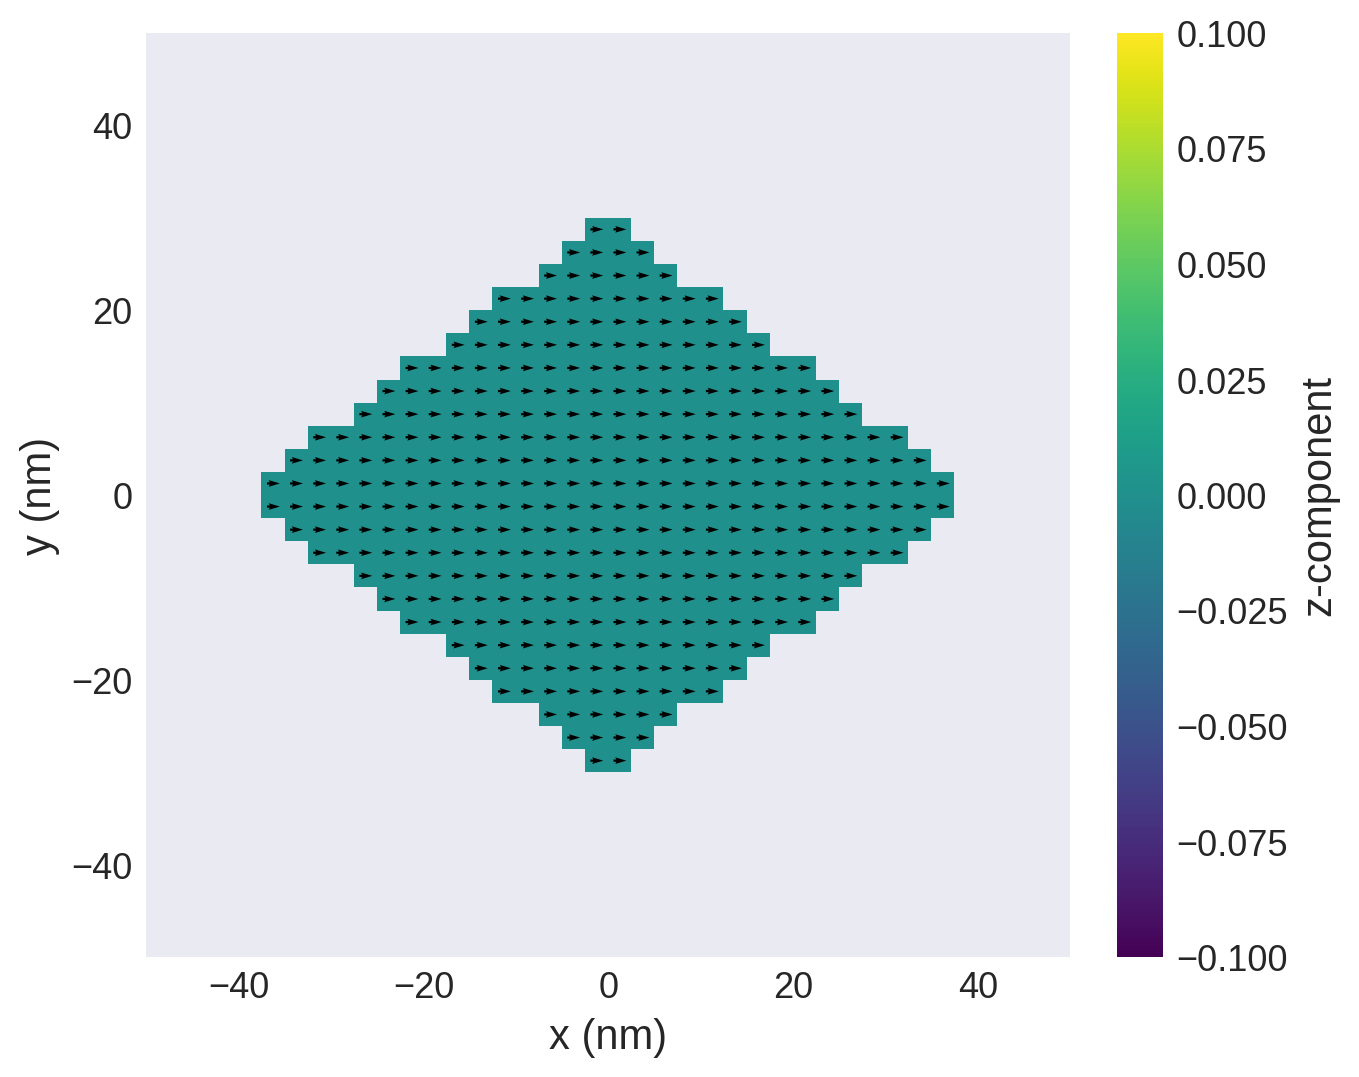

In [13]:
system.m.sel("z").mpl()

Run a hystersis loop from 0 to 500 mT in the y direction:

In [14]:
Hmin = (0, 0, 0)
Hmax = ((0.1, 500, 0) * u.mT).to(u.A / u.m)  # Convert to A/m for Ubermag compatibility
n = 101

hd = mc.HysteresisDriver()
hd.drive(system, Hsteps=[[Hmin, tuple(Hmax.value), n]])

Running OOMMF (ExeOOMMFRunner)[2025/06/02 14:51]... (4.2 s)


Extract entitles from the results of our field sweep:

In [15]:
H_y = me.H(
    system.table.data["By_hysteresis"].values  # simulation output in mT
    * u.Unit(system.table.units["By_hysteresis"]).to(u.A / u.m)  # conversion factor from mT to A/m
)
M_y = me.Entity("Magnetization", system.table.data["my"].values * Ms)

## Linear segment
Use `mammos-analysis` to find the properties of the linearized hysteresis loop.

In [16]:
results_linear = mammos_analysis.hysteresis.find_linear_segment(H_y, M_y, margin=0.05 * Ms, min_points=5)

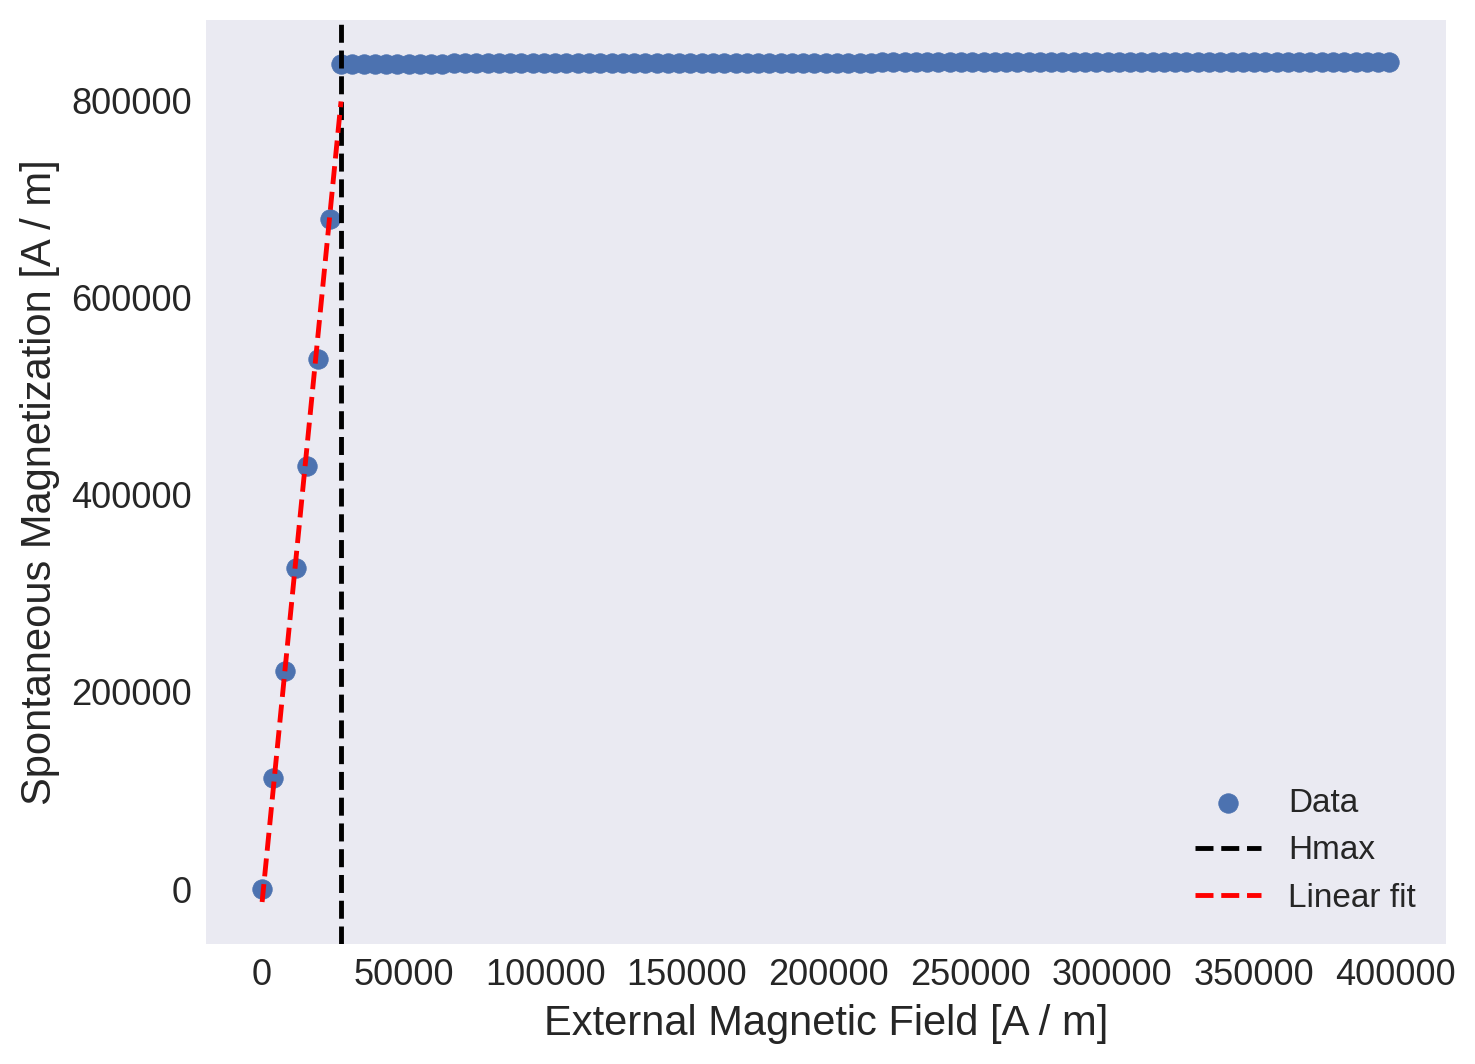

In [17]:
results_linear.plot();

In [18]:
results_linear.Hmax  # maximum field value of the linear region

ExternalMagneticField(value=27852.115010720376, unit=A / m)

In [19]:
results_linear.Mr  # crossing of linear fit and y axis

Remanence(value=-13192.415662203863, unit=A / m)

In [20]:
results_linear.gradient  # slope of the linear fit

<Quantity 29.16976731>

## Optimization

Here we use Bayesian optimization to maximize `Hmax` by optimizing the lengths of the diagnonals $s_x$ and $s_y$ of the diamond.

In [21]:
from bayes_opt import BayesianOptimization

Define the objective function:

In [22]:
def objective(sx, sy):
    system.m = df.Field(
        mesh, nvdim=3, value=(1, 0, 0), norm=lambda p: in_diamond(p, sx, sy), valid="norm"
    )  # Change shape
    hd.drive(system, Hsteps=[[Hmin, tuple(Hmax.value), n]], verbose=0)  # Field sweep
    H_y = me.H(system.table.data["By_hysteresis"].values * u.Unit(system.table.units["By_hysteresis"]).to(u.A / u.m))
    M_y = system.table.data["my"].values * Ms
    results_linear = mammos_analysis.hysteresis.find_linear_segment(
        H_y, M_y, margin=0.05 * Ms, min_points=2
    )  # Find linear segment
    return results_linear.Hmax.value

In [23]:
objective(19e-9, 39e-9)

3978.8735729668742

Running the simulation changes the `system` so we can view the new shape using:

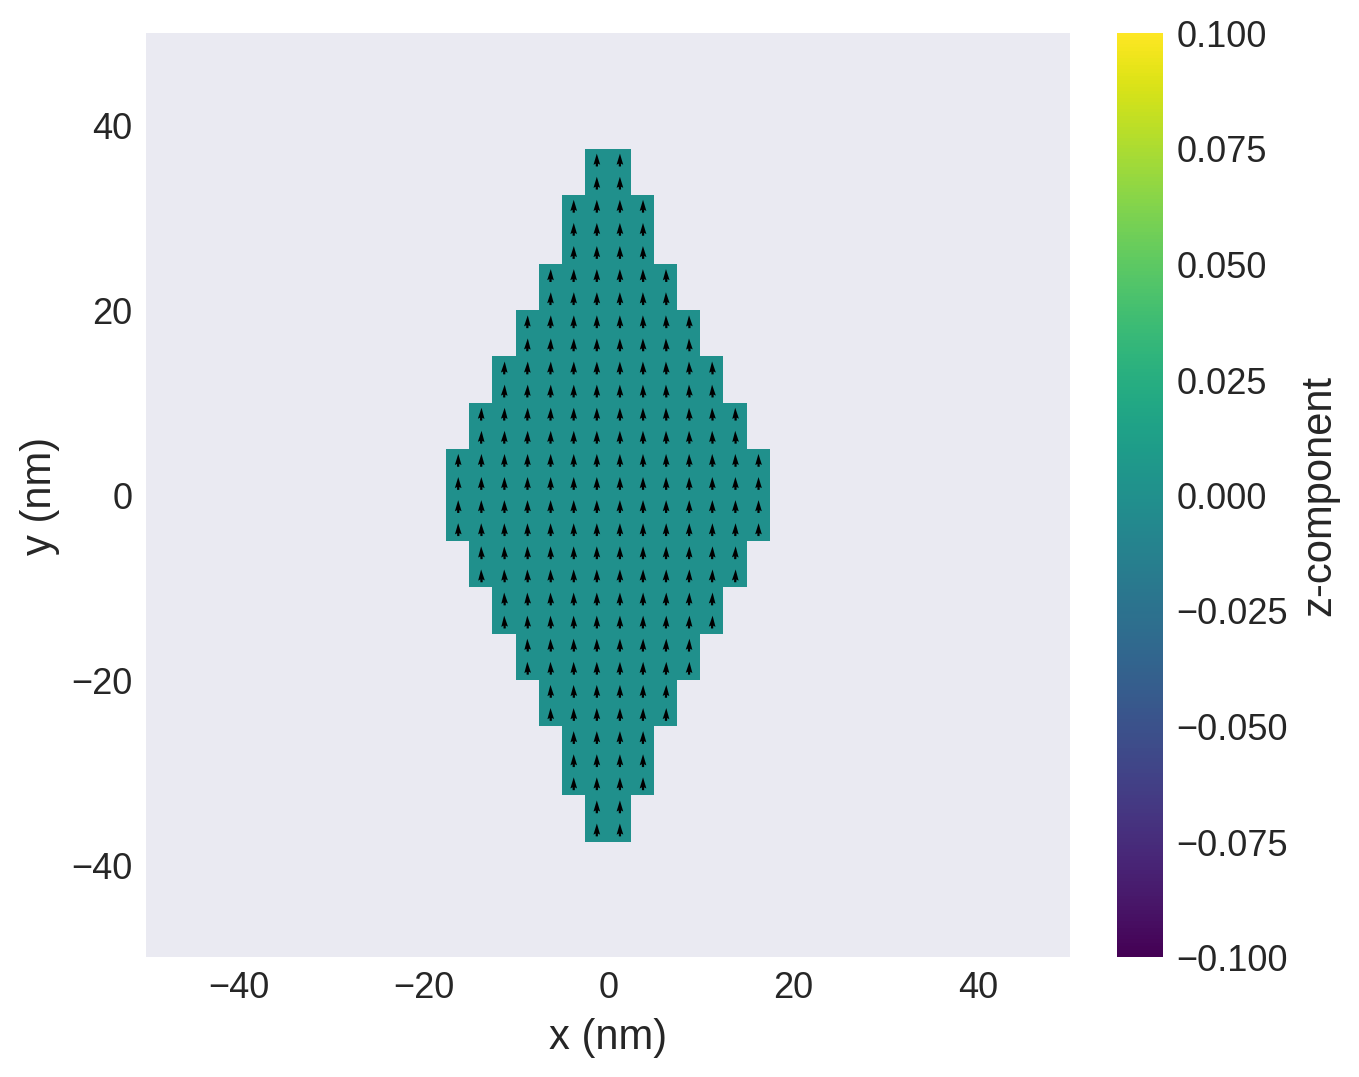

In [24]:
system.m.sel("z").mpl()

We define the bounds over which the optimizer can search:

In [25]:
pbounds = {"sx": (3e-9, np.sqrt(2) * 50e-9), "sy": (3e-9, np.sqrt(2) * 50e-9)}

Initialize the optimizer:

In [26]:
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

We maximize the objective function:

In [27]:
optimizer.maximize(
    init_points=10,
    n_iter=20,
)

|   iter    |  target   |    sx     |    sy     |
-------------------------------------------------
| 1         | 3.979e+03 | 3.124e-08 | 5.177e-08 |
| 2         | 3.979e+03 | 3.008e-09 | 2.347e-08 |
| 3         | 5.57e+04  | 1.294e-08 | 9.252e-09 |
| 4         | 3.979e+03 | 1.561e-08 | 2.64e-08  |
| 5         | 3.979e+03 | 2.987e-08 | 3.948e-08 |
| 6         | 3.979e+03 | 3.138e-08 | 4.94e-08  |
| 7         | 3.979e+03 | 1.684e-08 | 6.246e-08 |
| 8         | 3.979e+03 | 4.854e-09 | 4.84e-08  |
| 9         | 3.979e+03 | 3.126e-08 | 4.083e-08 |
| 10        | 3.979e+03 | 1.251e-08 | 1.641e-08 |
| 11        | 3.979e+05 | 6.878e-08 | 3.093e-09 |
| 12        | 3.979e+05 | 7.033e-08 | 3.693e-09 |
| 13        | 3.979e+05 | 7.042e-08 | 3.294e-09 |
| 14        | 3.979e+05 | 7.051e-08 | 3.277e-09 |
| 15        | 3.979e+05 | 7.065e-08 | 3.624e-09 |
| 16        | 3.979e+05 | 7.022e-08 | 3.215e-09 |
| 17        | 3.979e+05 | 7.007e-08 | 3.54e-09  |
| 18        | 3.979e+05 | 7.06e-08  | 3.728e-09 |


In [28]:
print(optimizer.max)

{'target': 397887.35729668743, 'params': {'sx': 6.878354081128767e-08, 'sy': 3.092785135534182e-09}}


Lets run the simulation again with the best values to check the simulation and the shape.

In [29]:
sx, sy = optimizer.max["params"]["sx"], optimizer.max["params"]["sy"]
system.m = df.Field(mesh, nvdim=3, value=(1, 0, 0), norm=lambda p: in_diamond(p, sx, sy), valid="norm")  # Change shape
hd.drive(system, Hsteps=[[Hmin, tuple(Hmax.value), n]], verbose=0)  # Field sweep
H_y = me.H(system.table.data["By_hysteresis"].values * u.Unit(system.table.units["By_hysteresis"]).to(u.A / u.m))
M_y = system.table.data["my"].values * Ms
results_linear = mammos_analysis.hysteresis.find_linear_segment(
    H_y, M_y, margin=0.01 * Ms, min_points=2
)  # Find linear segment

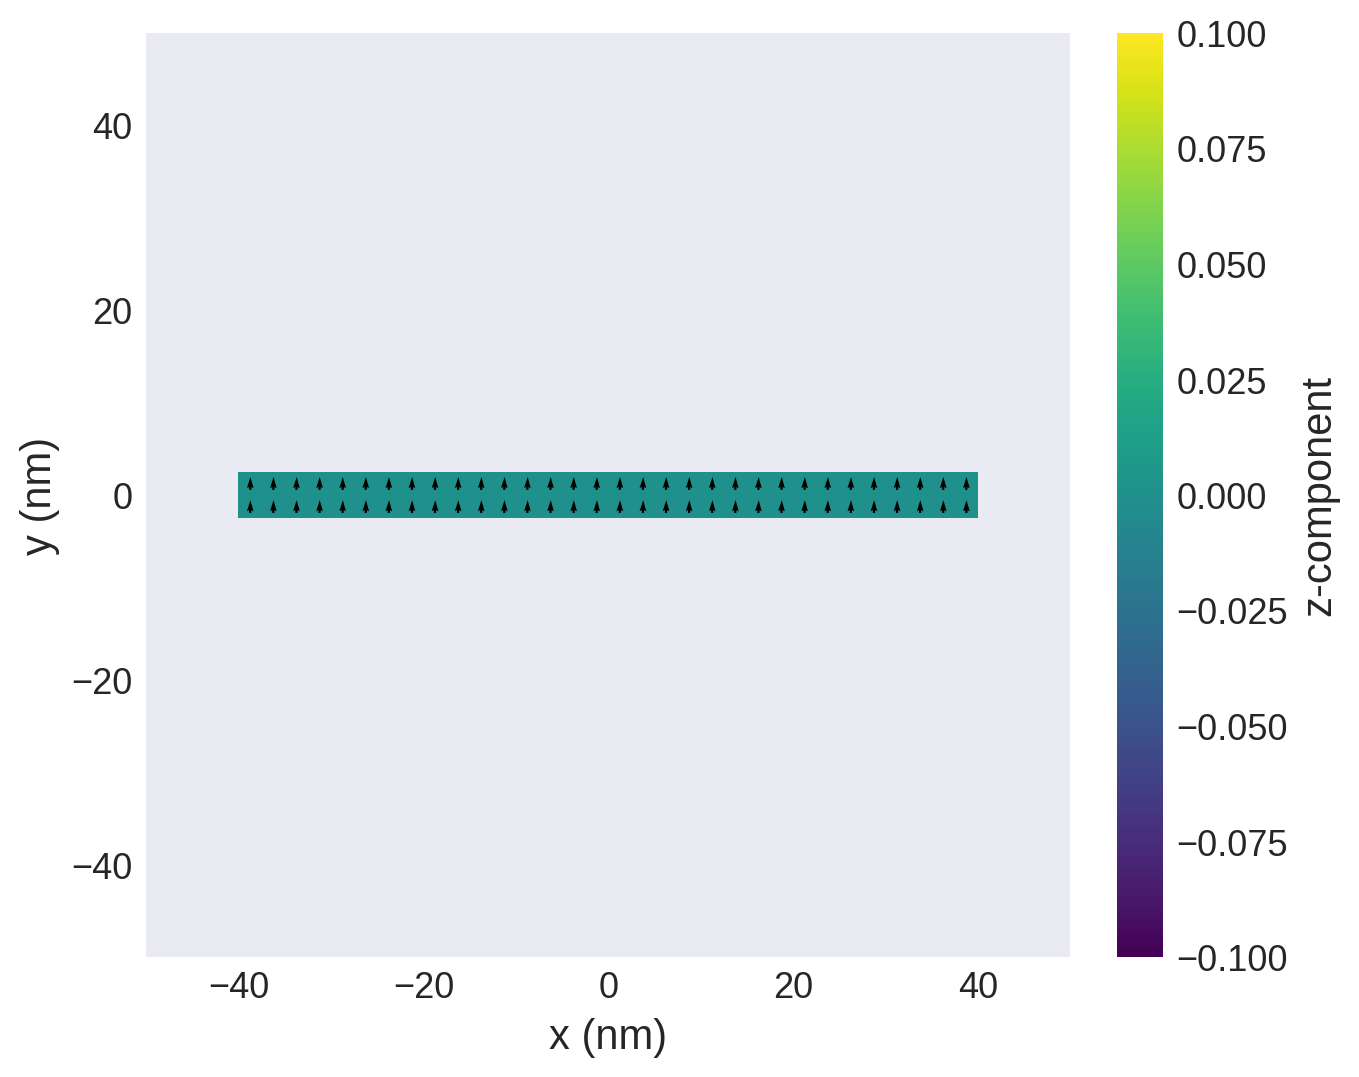

In [30]:
system.m.sel("z").mpl()

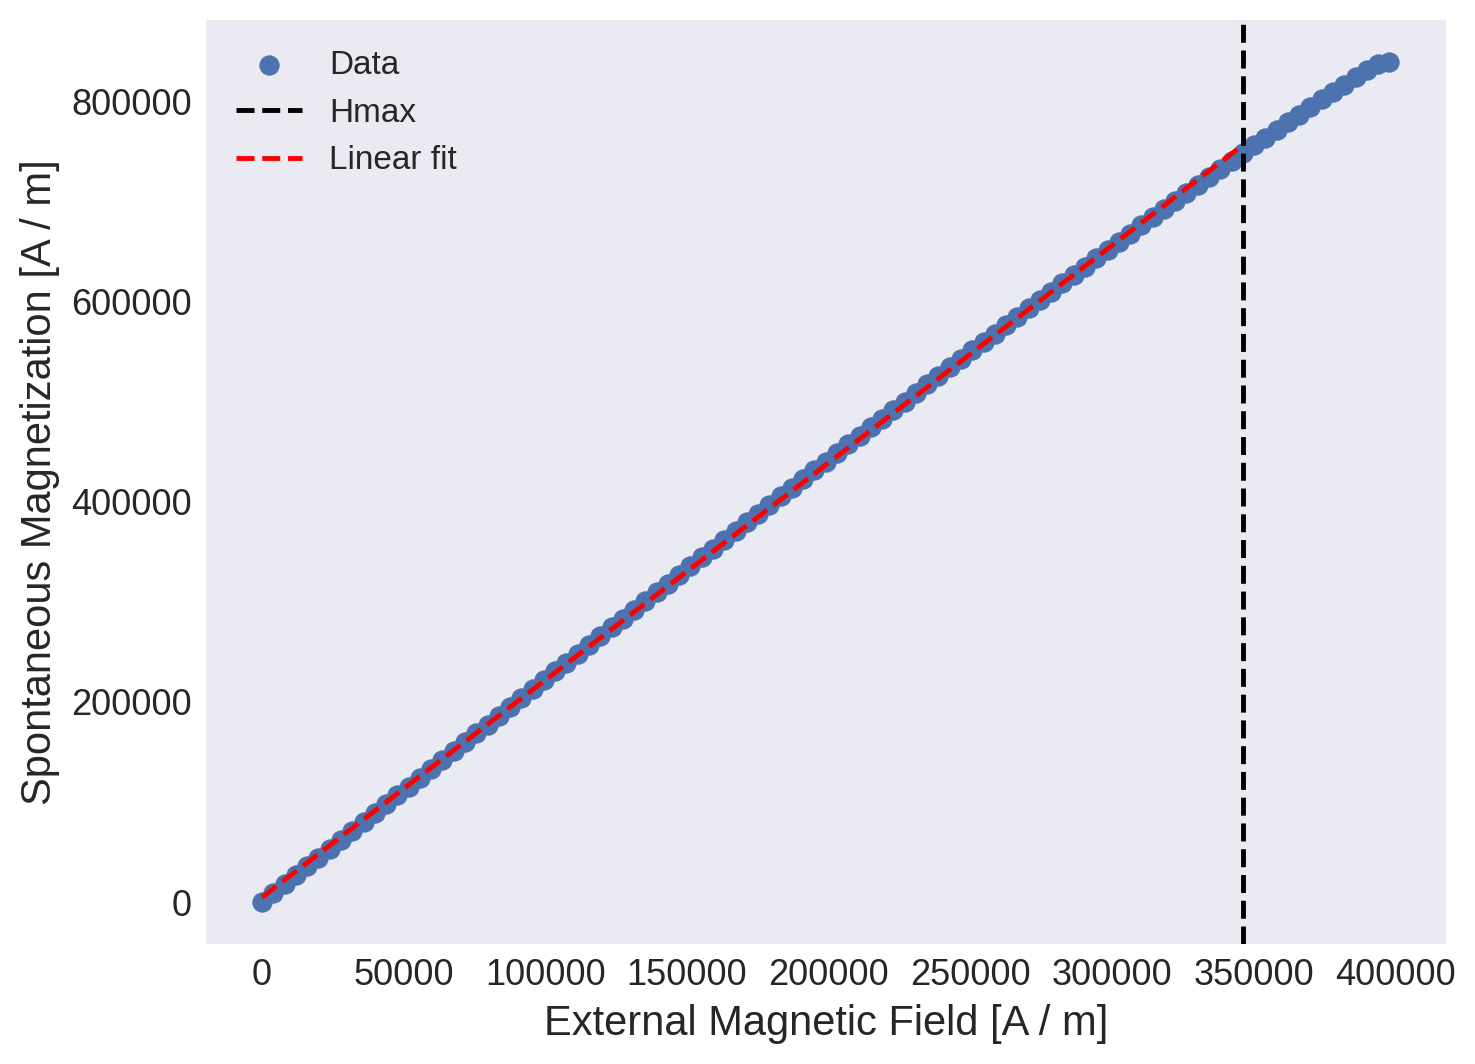

In [31]:
results_linear.plot();

We can also use the built in tools of `ubermag` to visualize the magnetization as a function of applied field directly. 

In [32]:
data = md.Data(system.name)

drive = data[-1]
drive = drive.register_callback(lambda x: x.sel("z"))  # TODO: Remove when new ubermag is released

drive.hv(kdims=["x", "y"])

:DynamicMap   [B_hysteresis]
   :Overlay
      .Image.I       :Image   [x,y]   (field)
      .VectorField.I :VectorField   [x,y]   (angle,mag)